In [ ]:
!pip install slimevolleygym dm-sonnet trfl

     |████████████████████████████████| 254 kB 12.5 MB/s 
     |████████████████████████████████| 104 kB 61.0 MB/s 


In [ ]:
import gym
import slimevolleygym
import numpy as np
import tensorflow as tf
from typing import NamedTuple
import sonnet as snt
import trfl
import copy
import matplotlib.pyplot as plt


In [ ]:
ACTION_LOOKUP = [
  [0, 0, 0], # NOOP
  [1, 0, 0], # LEFT (forward)
  [1, 0, 1], # UPLEFT (forward jump)
  [0, 0, 1], # UP (jump)
  [0, 1, 1], # UPRIGHT (backward jump)
  [0, 1, 0]  # RIGHT (backward)
] 

In [ ]:

def random_policy(obs):
  action_id = np.random.randint(6)
  return ACTION_LOOKUP[action_id], action_id


In [ ]:
def run_one_episode(policy, env):
  obs = env.reset()
  done = False
  total_reward = 0

  while not done:
    action, action_id = policy(obs)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    # env.render()

  return total_reward

In [ ]:
env = gym.make("SlimeVolley-v0")


In [ ]:
returns = []
for episode in range(100):
  reward = run_one_episode(random_policy, env)
  returns.append(reward)
  
print("av. returns = ", np.mean(returns))



av. returns =  -4.87


In [ ]:
class Batch(NamedTuple):
    """Container for a batch of experience tuples."""
    observation: np.array
    next_observation: np.array
    reward: np.array
    action: np.array
    done: np.array


class TransitionBuffer:

    def __init__(
        self,
        observation_dim,
        buffer_size=5000,  # Num episodes
        batch_size=32
    ):
        self.observation_dim = observation_dim
        self.buffer_size = buffer_size
        self.batch_size = batch_size

        observation_buffer_shape = (buffer_size, observation_dim)
        self.observation_buffer = np.zeros(observation_buffer_shape, dtype='float32')
        self.next_observation_buffer = np.zeros(observation_buffer_shape, dtype='float32')

        action_buffer_shape = (buffer_size, )
        self.action_buffer = np.zeros(action_buffer_shape, dtype='int32')
        self.reward_buffer = np.zeros(action_buffer_shape, dtype='float32')
        self.dones_buffer = np.zeros(action_buffer_shape, dtype='float32')

        self.counter = 0

    def can_sample_batch(self):
        return self.counter >= self.batch_size  # Cannot sample more than the batch size

    def add(
        self,
        batch: Batch,
    ):
        idx = self.counter % self.buffer_size  # FIFO

        self.observation_buffer[idx] = batch.observation
        self.next_observation_buffer[idx] = batch.next_observation
        self.action_buffer[idx] = batch.action
        self.reward_buffer[idx] = batch.reward
        self.dones_buffer[idx] = batch.done

        self.counter += 1

    def sample(self):
        assert self.can_sample_batch()

        max_idx = min(self.counter, self.buffer_size)
        idxs = np.random.choice(max_idx, size=self.batch_size, replace=True)

        observation_batch = tf.convert_to_tensor(self.observation_buffer[idxs])
        next_observation_batch = tf.convert_to_tensor(self.next_observation_buffer[idxs])
        action_batch = tf.convert_to_tensor(self.action_buffer[idxs])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[idxs])
        dones_batch = tf.convert_to_tensor(self.dones_buffer[idxs])

        batch = Batch(
            observation=observation_batch,
            next_observation=next_observation_batch,
            action=action_batch,
            reward=reward_batch,
            done=dones_batch,
        )

        return batch

In [ ]:
def run_one_episode(policy, env, replay):
  obs = env.reset()
  done = False
  total_reward = 0

  while not done:
    action, action_id = policy(obs)
    next_obs, reward, done, info = env.step(action)
    batch = Batch(observation = obs, next_observation = next_obs, action = action_id, reward = reward, done = done)
    replay.add(batch)
    total_reward += reward
    # env.render()
    obs = next_obs

  return total_reward

In [ ]:
obs = env.reset()
print(obs.shape)


(12,)


In [ ]:
replay = TransitionBuffer(12)

In [ ]:
run_one_episode(random_policy, env, replay)

-5

In [ ]:
returns = []
for episode in range(100):
  reward = run_one_episode(random_policy, env, replay)
  returns.append(reward)
  
print("av. returns = ", np.mean(returns))

av. returns =  -4.84


In [ ]:
batch = replay.sample()

In [ ]:
class Actor:
  def __init__(self, num_actions, q_net, eps_decay = 0.999995, eps_min=0.05):
    self.eps_decay = eps_decay
    self.eps_min = eps_min
    self.eps = 1
    self.num_actions = num_actions
    self.q_net = q_net

  def policy(self, obs):
    if np.random.random() < self.eps:
      action_id = np.random.randint(6)
    else: 
      obs = tf.convert_to_tensor(obs, dtype = 'float32')
      obs = tf.reshape(obs, (1,-1))
      q_values = self.q_net(obs)
      action_id = tf.argmax(q_values, axis = -1).numpy()[0]
    action = ACTION_LOOKUP[action_id]
    self.decrement_epsilon()
    return action, action_id

  def decrement_epsilon(self):
    self.eps = max(self.eps_min, self.eps_decay*self.eps)


In [ ]:
q_net = snt.nets.MLP((64, 6))
actor = Actor(6, q_net)

In [ ]:
def run_one_episode(actor, env, replay):
  obs = env.reset()
  done = False
  counter = 0
  total_reward = 0

  while not done:
    action, action_id = actor.policy(obs)
    #print(actor.eps)
    next_obs, reward, done, info = env.step(action)
    batch = Batch(observation = obs, next_observation = next_obs, action = action_id, reward = reward, done = done)
    replay.add(batch)
    total_reward += reward
    # env.render()
    obs = next_obs
    counter += 1

  return total_reward, counter

In [ ]:
run_one_episode(actor, env, replay)

-5

In [ ]:
class Learner:
  def __init__(self, q_net, target_q_net, lr = 5e-4, discount = 0.99, target_update_period = 100):
    self.q_net = q_net
    self.target_q_net = target_q_net
    self.lr = lr
    self.discount = discount
    self.target_update_period = target_update_period
    self.optimiser = snt.optimizers.Adam(lr)
    self.learning_steps = 0 


  @tf.function
  def learn(self, batch):
    obs = batch.observation
    next_obs = batch.next_observation
    action_id = batch.action
    reward = batch.reward
    done = batch.done

    with tf.GradientTape() as tape:

      q_values = self.q_net(obs)  #[B, Act]
      selected_q_value = trfl.batched_index(q_values, action_id) #[B]

      # Standard Q-learning
      next_q_values = self.target_q_net(next_obs)
      max_next_q_value = tf.reduce_max(next_q_values, axis=-1)

      # Bellman target
      target = reward + self.discount * (1 - done) * max_next_q_value

      # Temporal difference
      td_error = selected_q_value - target

      # Mean-squared error
      loss = tf.reduce_mean(td_error ** 2)


    variables = self.q_net.trainable_variables #from sonnet
    gradients = tape.gradient(loss, variables)
    self.optimiser.apply(updates=gradients, parameters=variables)

    #self._update_target_network()

    return loss

  def _update_target_network(self):
        """Update target network."""
        if self.learning_steps % self.target_update_period == 0:
            online_variables = (*self.q_net.variables,)
            target_variables = (*self.target_q_net.variables,)

            for src, dest in zip(online_variables, target_variables):
                dest.assign(src)

        self.learning_steps += 1

In [ ]:

target_q_net = copy.deepcopy(q_net)
learner = Learner(q_net, target_q_net)


In [ ]:
batch = replay.sample()
learner.learn(batch)

<tf.Tensor: shape=(), dtype=float32, numpy=0.07789205>

In [ ]:
def train(learner, actor, replay_buffer, env, num_episodes = 10000, learner_steps_per_episode = 100):

  episode_returns = []
  ep_lengths = []

  for episode in range(num_episodes):

    episode_return, ep_length = run_one_episode(actor, env, replay_buffer)
    episode_returns.append(episode_return)
    ep_lengths.append(ep_length)

    losses = []
    for learner_step in range(learner_steps_per_episode):
      batch = replay.sample()
      loss = learner.learn(batch)
      learner._update_target_network()
      losses.append(loss)
    
    if episode % 10 == 0:
      print(f"episode: {episode}  episode_return: {episode_return}  epsiode length: {np.mean(ep_lengths[-50:])}  smoothed episode return: {np.mean(episode_returns[-50:])}  epsilon: {actor.eps} loss: {np.mean(losses)}")


In [ ]:
q_net = snt.nets.MLP((64, 6))
target_q_net = copy.deepcopy(q_net)
actor = Actor(6, target_q_net, eps_decay = 0.999999)
learner = Learner(q_net, target_q_net)
replay = TransitionBuffer(12, buffer_size = 1_000_000)


train(learner, actor, replay, env)

episode: 0  episode_return: -5  epsiode length: 621.0  smoothed episode return: -5.0  epsilon: 0.9993791924702655 loss: 0.5677425265312195
episode: 10  episode_return: -5  epsiode length: 563.2727272727273  smoothed episode return: -5.0  epsilon: 0.9938231525457847 loss: 0.05183618143200874
episode: 20  episode_return: -5  epsiode length: 553.2857142857143  smoothed episode return: -5.0  epsilon: 0.9884482341656537 loss: 0.06915715336799622
episode: 30  episode_return: -5  epsiode length: 562.516129032258  smoothed episode return: -4.967741935483871  epsilon: 0.9827131534236025 loss: 0.10333018004894257
episode: 40  episode_return: -5  epsiode length: 551.439024390244  smoothed episode return: -4.926829268292683  epsilon: 0.9776446570641721 loss: 0.08467869460582733
episode: 50  episode_return: -5  epsiode length: 557.56  smoothed episode return: -4.92  epsilon: 0.9719032521989738 loss: 0.0970364660024643
episode: 60  episode_return: -5  epsiode length: 572.88  smoothed episode return:

KeyboardInterrupt: ignored

In [ ]:
LEARN_EVERY = 8

q_net = snt.nets.MLP((128,128, 6))
target_q_net = copy.deepcopy(q_net)

actor = Actor(6, target_q_net)
learner = Learner(q_net, target_q_net)
replay = TransitionBuffer(12, batch_size=256, buffer_size=1000000)

env = gym.make("SlimeVolley-v0")

t = 0
returns = []
lens = []
losses = []
for e in range(4000):
    done = False
    ep_return = 0
    obs = env.reset()
    ep_len = 0
    while not done:

        action, action_id = actor.policy(obs)

        next_obs, reward, done, _ = env.step(action)

        batch = Batch(
            observation=obs,
            next_observation=next_obs,
            reward=reward,
            done=done,
            action=action_id,
        )

        replay.add(batch)

        if t % LEARN_EVERY == 0 and replay.can_sample_batch():
            batch = replay.sample()
            loss = learner.learn(batch)
            learner._update_target_network()
            losses.append(loss)


        obs = next_obs
        ep_return += reward
        t += 1
        ep_len += 1

    returns.append(ep_return)
    lens.append(ep_len)

    if e % 50 == 0:
        print(f"ep: {e}  t: {t} ep_return: {ep_return}  smoothed ep_return: {np.mean(returns[-100:])}   ep_len: {ep_len}   smoothed ep_len: {np.mean(lens[-100:])}  eps: {actor.eps} loss: {np.mean(losses[-10:])} ")

ep: 0  t: 686 ep_return: -5  smoothed ep_return: -5.0   ep_len: 686   smoothed ep_len: 686.0  eps: 0.9965758671844728 loss: 0.01571144536137581 
ep: 50  t: 29339 ep_return: -5  smoothed ep_return: -4.96078431372549   ep_len: 591   smoothed ep_len: 575.2745098039215  eps: 0.8635570055367972 loss: 0.011893055401742458 
ep: 100  t: 57955 ep_return: -5  smoothed ep_return: -4.95   ep_len: 533   smoothed ep_len: 572.69  eps: 0.7484314036279179 loss: 0.016856724396348 
ep: 150  t: 86463 ep_return: -5  smoothed ep_return: -4.91   ep_len: 747   smoothed ep_len: 571.24  eps: 0.6490042064968339 loss: 0.025107672438025475 
ep: 200  t: 115387 ep_return: -5  smoothed ep_return: -4.89   ep_len: 461   smoothed ep_len: 574.32  eps: 0.5616162776078778 loss: 0.019702672958374023 
ep: 250  t: 146757 ep_return: -5  smoothed ep_return: -4.87   ep_len: 552   smoothed ep_len: 602.94  eps: 0.48008753147130684 loss: 0.021396033465862274 
ep: 300  t: 175963 ep_return: -5  smoothed ep_return: -4.86   ep_len: 542

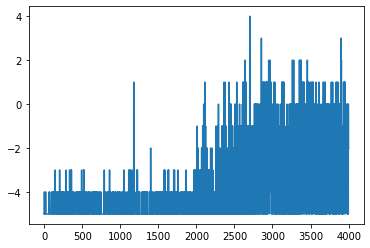

In [ ]:
%matplotlib inline
plt.plot(returns)


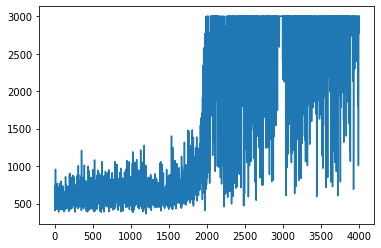

In [ ]:
plt.plot(lens)

In [ ]:
  N = len(returns)
  running_avg_returns = np.empty(N)
  for t in range(N):
    running_avg_returns[t] = np.mean(returns[max(0, t-20):(t+1)])



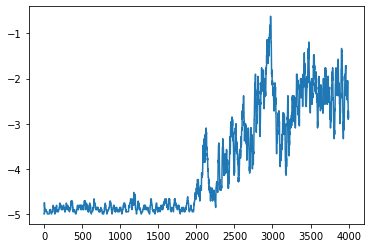

In [ ]:
plt.plot(running_avg)

In [ ]:
  N = len(lens)
  running_avg_lens = np.empty(N)
  for t in range(N):
    running_avg_lens[t] = np.mean(lens[max(0, t-20):(t+1)])

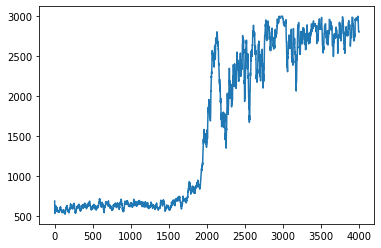

In [ ]:
plt.plot(running_avg_lens)

In [ ]:
print(lens)

[686, 404, 501, 734, 472, 720, 689, 451, 417, 560, 894, 957, 710, 521, 577, 524, 630, 527, 569, 574, 567, 664, 524, 527, 452, 555, 574, 582, 655, 535, 432, 711, 495, 421, 503, 765, 455, 694, 572, 668, 627, 658, 624, 431, 437, 459, 449, 605, 571, 419, 591, 604, 386, 495, 523, 716, 436, 597, 684, 700, 601, 648, 484, 695, 560, 765, 578, 526, 563, 614, 721, 527, 688, 428, 643, 590, 613, 669, 498, 536, 428, 565, 431, 579, 470, 707, 800, 541, 459, 630, 587, 502, 473, 415, 531, 484, 556, 492, 653, 692, 533, 683, 509, 470, 594, 609, 567, 735, 579, 507, 450, 490, 594, 613, 524, 594, 507, 593, 644, 493, 479, 479, 392, 512, 609, 409, 539, 625, 527, 563, 566, 445, 472, 657, 414, 537, 595, 576, 509, 620, 598, 613, 588, 857, 660, 597, 641, 666, 560, 701, 747, 454, 614, 685, 545, 679, 667, 580, 531, 577, 432, 706, 730, 586, 572, 544, 570, 483, 519, 498, 437, 563, 506, 626, 443, 729, 529, 482, 588, 679, 476, 570, 689, 513, 533, 622, 397, 413, 694, 413, 673, 571, 685, 510, 681, 891, 601, 680, 582, 715,

In [ ]:
print(returns)

[-5, -5, -5, -4, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -4, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -4, -5, -5, -5, -4, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -4, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -4, -5, -4, -5, -4, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -3, -4, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -4, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -4, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -4, -5, -5, -5, -5, -5, -4, -5, -4, -5, -5, -5, -5, -5, -5, -3, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -4, -5, -5, -4, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -4, -5, -5, -4, -5, -5, -5, -4, -5, -5, -5, -5, -5, -5, -5, -4,

In [ ]:
from numpy import savetxt
savetxt('av_returns.csv', running_avg_returns, delimiter=',')

In [ ]:
savetxt('av_lens.csv', running_avg_lens, delimiter=',')